In [1]:
from sar_sim import *
import numpy as np

In [2]:
# Define SAR sensor parameters
sensor = SensorParameters(
    carrier_frequency_hz=360e6,
    bandwidth_hz=50e6,
    pulse_width_s=3e-6,
    PRF_hz=5_000, # To meet the Nyquist criterion, PRF > (4v)/(λ) * sin (grazing_angle)
    sampling_frequency_hz=(360e6+25e6)*2.5,
    sensor_speed_mps=7500.0,
    sensor_height_m=100_000.0,
    grazing_angle_deg=40.0,
    swath_m=5_000.0,
    range_width_m=5_000.0,
    azimuth_resolution_m=2.5,
    integration_angle_rad=calculate_integration_angle(1.2, 3e8/360e6, 2.0)
)

# Define a single point target at an offset
target_pos = (0.0, 0.0, 0.0)


delay: 0.0010419429745525122


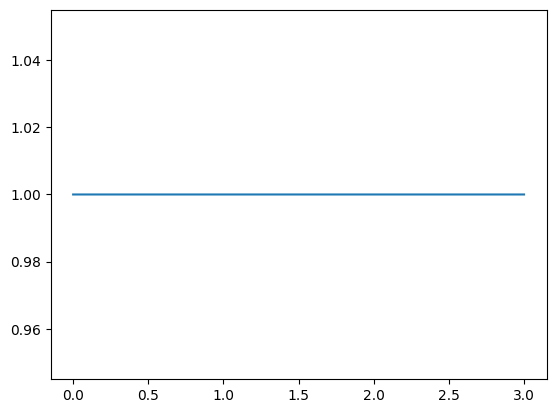

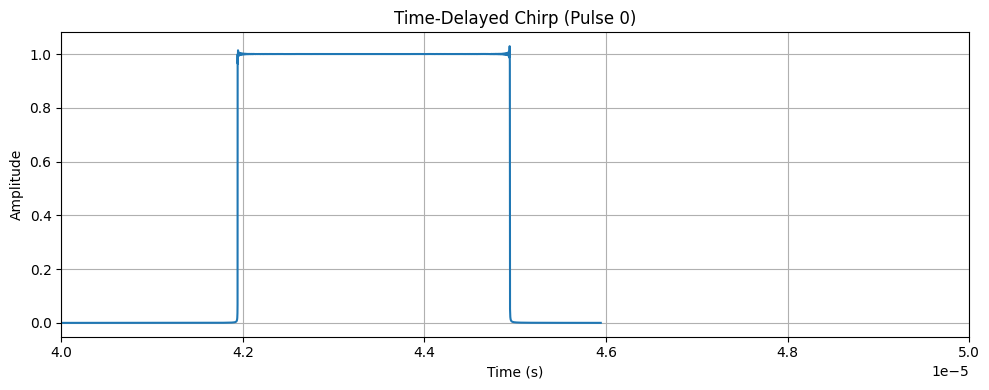

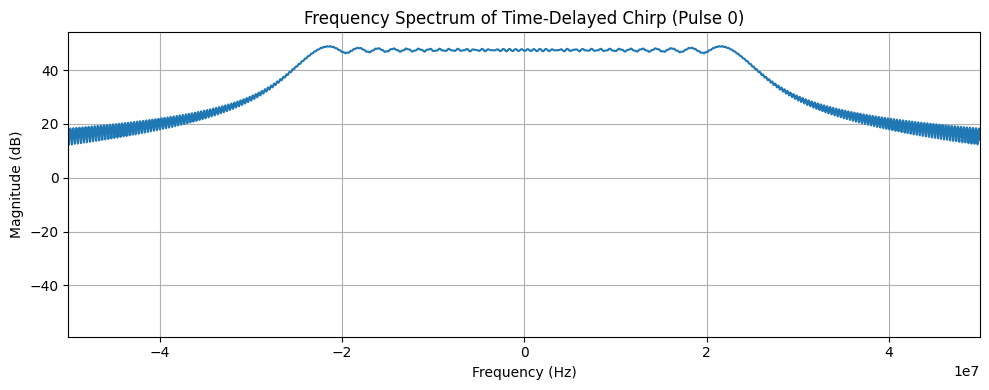

In [3]:
# Simulate raw SAR data
raw_data, time_result, t_start = simulate_raw_data(sensor, target_pos, t_start=1000.0e-6)

# Compute time delays for the target
time_result_target = compute_target_time_delays(sensor, target_pos)

In [4]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go


def plot_raw_sar_data_interactive(
    raw_data: np.ndarray,
    sampling_frequency_hz: float,
    downsample_fast: int = 10,
    start_time_s: float = 0.0,
    xlim_microseconds: tuple = None,
    title: str = "Simulated Raw SAR Data"
):
    """
    Interactive plot of raw SAR data (Pulse Index vs Fast Time) using Plotly.

    Parameters:
    - raw_data: 2D array [pulses × fast-time]
    - sampling_frequency_hz: Sampling rate in Hz
    - downsample_fast: Downsampling factor in fast-time axis
    - start_time_s: Start time (in seconds) of the fast-time window
    - xlim_microseconds: Optional x-axis limit in µs
    - title: Plot title
    """
    num_pulses, num_fast_time = raw_data.shape
    if downsample_fast <= 0:
        downsample_fast = 1

    # Fast-time axis (downsampled) in microseconds
    fast_time_axis_us = (np.arange(0, num_fast_time, downsample_fast) / sampling_frequency_hz + start_time_s) * 1e6

    # Downsampled amplitude (optional: use dB)
    amp_matrix = np.abs(raw_data[:, ::downsample_fast])

    # Suggest xlim
    energy = np.abs(raw_data).max(axis=0)
    nonzero_indices = np.where(energy > 0.0)[0]

    if len(nonzero_indices) > 0 and xlim_microseconds is None:
        start_us = (nonzero_indices[0] / sampling_frequency_hz + start_time_s) * 1e6
        end_us = (nonzero_indices[-1] / sampling_frequency_hz + start_time_s) * 1e6
        xlim_microseconds = (start_us - 1, end_us + 1)
        print(f"Suggested xlim: ({start_us:.1f} μs, {end_us:.1f} μs)")
    elif xlim_microseconds is None:
        xlim_microseconds = (fast_time_axis_us[0], fast_time_axis_us[-1])

    # Create figure
    fig = go.Figure(data=go.Heatmap(
        z=amp_matrix,
        x=fast_time_axis_us,
        y=np.arange(num_pulses),
        colorscale='Viridis',
        colorbar=dict(title="Amplitude"),
        zsmooth='best'
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Fast Time (μs)",
        yaxis_title="Pulse Index",
        xaxis_range=xlim_microseconds,
        height=600
    )

    fig.show()


In [ ]:
# Plot SAR raw data (Pulse Index vs Fast Time)
plot_raw_sar_data_interactive(raw_data, sensor.sampling_frequency_hz, start_time_s=t_start, xlim_microseconds=(1035, 1050))

In [ ]:
# Check phase vs azimuth
plot_phase_vs_azimuth(raw_data, sensor.sampling_frequency_hz, fast_time_index=0)


In [ ]:
# Plot time delay of the target
plot_slant_range_time_delays(time_result_target)

In [ ]:
plot_chirp_frequency_spectrum(np.fft.ifftshift(raw_data[1]), sensor.sampling_frequency_hz)

## Scenario 1: Simulate range migration then compression

In [ ]:
# Perform range migration alignment
aligned_data = perform_range_migration(
    compressed_data=raw_data,
    sensor=sensor,
    target_position=target_pos,
    reference_signal_frequency_hz=sensor.carrier_frequency_hz,
    sampling_frequency=sensor.sampling_frequency_hz,
    chirp_start_time=t_start
)

In [ ]:
# Plot SAR raw data (Pulse Index vs Fast Time)
plot_raw_sar_data(aligned_data, sensor.sampling_frequency_hz, downsample_fast=10)

In [ ]:
# Perform range compression via matched filtering
compressed_data = simulate_range_compression(aligned_data, sensor)
# Plot the compressed SAR data
plot_raw_sar_data(compressed_data, sensor.sampling_frequency_hz, downsample_fast=10)

In [ ]:
plot_chirp_frequency_spectrum(raw_data[0], sensor.sampling_frequency_hz)

In [ ]:
plot_chirp_frequency_spectrum(compressed_data[0], sensor.sampling_frequency_hz)

In [ ]:
# Check phase vs azimuth
plot_phase_vs_azimuth(aligned_data, sensor.sampling_frequency_hz, fast_time_us=0)

## Scenario 2: Simulate Range Compression then migrate

In [4]:
# Perform range compression via matched filtering
compressed_data = simulate_range_compression(raw_data, sensor)

Suggested xlim: (0.0 μs, 45.9 μs)


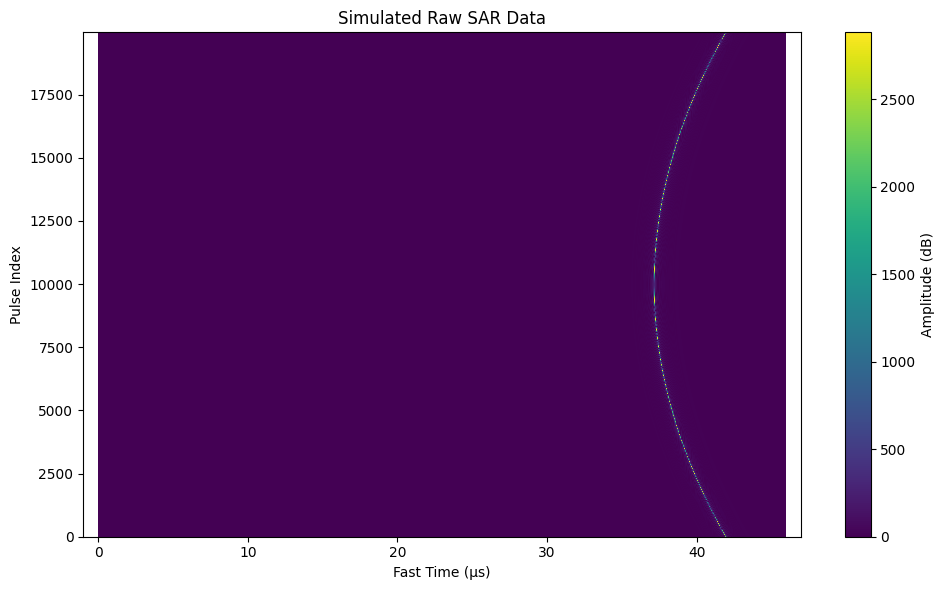

In [5]:
# Plot compressed data
plot_raw_sar_data(compressed_data, sensor.sampling_frequency_hz)

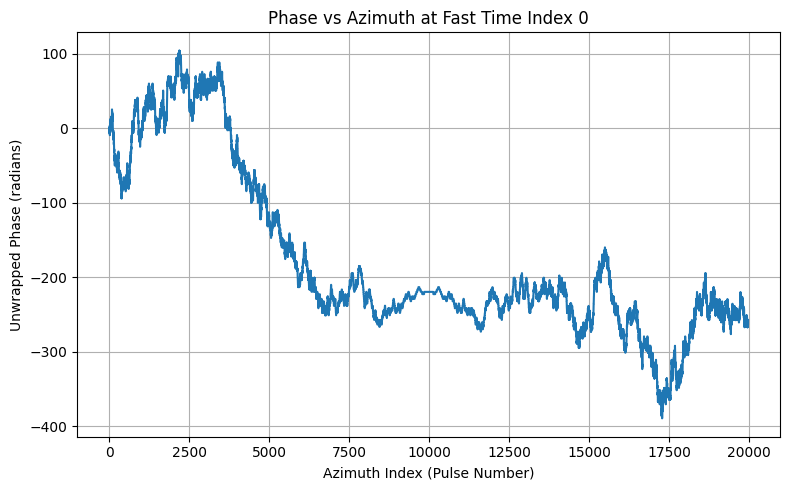

In [6]:
# Check phase vs azimuth
plot_phase_vs_azimuth(compressed_data, sensor.sampling_frequency_hz, fast_time_us=0)

In [7]:
# # Perform range migration alignment
# aligned_data = perform_range_migration(
#     compressed_data=compressed_data,
#     sensor=sensor,
#     target_position=target_pos,
#     reference_signal_frequency_hz=sensor.carrier_frequency_hz,
#     sampling_frequency=sensor.sampling_frequency_hz
# )

# Perform FFT along fast-time axis (axis=1)
compressed_data_fft = np.fft.fft(compressed_data, axis=1)

# Frequency axis
freqs = np.fft.fftfreq(compressed_data.shape[1], d=1 / sensor.sampling_frequency_hz)

# Phase shift matrix: [num_pulses x num_freqs]
phase_shift_matrix = np.exp(1j * 2 * np.pi * np.outer(time_result_target, freqs))

# Apply phase shift
aligned_data_fft = compressed_data_fft * phase_shift_matrix

# Inverse FFT to return to time domain
aligned_data = np.fft.ifft(aligned_data_fft, axis=1)



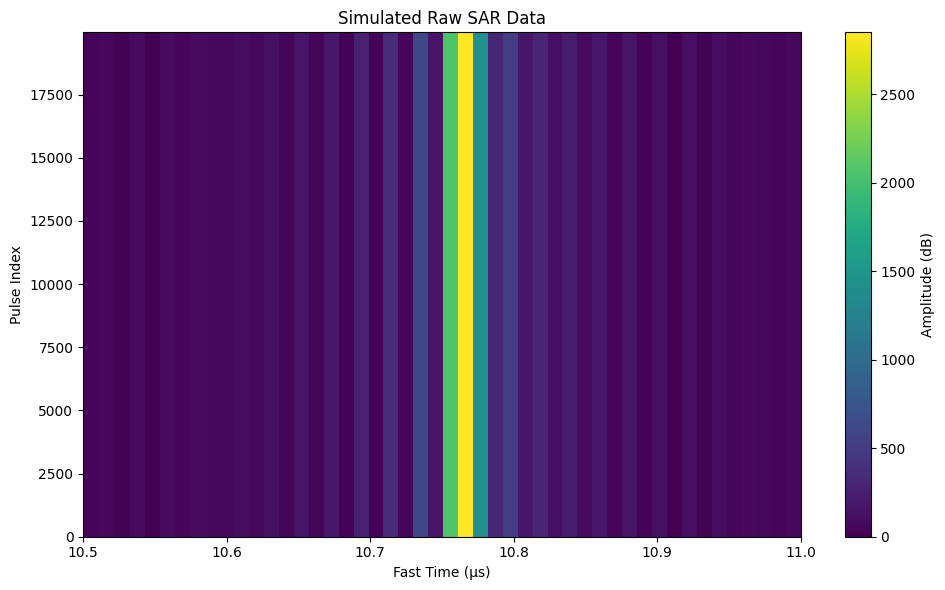

In [8]:
# Plot the aligned data
plot_raw_sar_data(aligned_data, sensor.sampling_frequency_hz, downsample_fast=10, xlim_microseconds=(10.5, 11))

In [ ]:
import numpy as np

# Compute magnitude of aligned data
magnitude = np.abs(aligned_data)

# Find global peak index
peak_idx = np.unravel_index(np.argmax(magnitude), magnitude.shape)
az_idx, fast_time_idx = peak_idx

# Convert fast-time index to microseconds
fast_time_us = fast_time_idx / sensor.sampling_frequency_hz * 1e6

print(f"Fast-Time Index = {fast_time_idx} ({fast_time_us:.5f} µs)")



Fast-Time Index = 10358 (10.76156 µs)


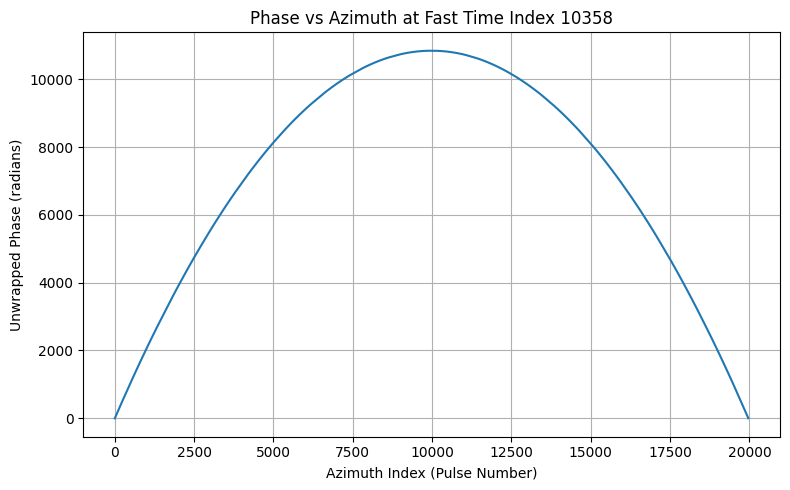

In [57]:
# Check phase vs azimuth
plot_phase_vs_azimuth(aligned_data, sensor.sampling_frequency_hz, fast_time_us=10.76156)

## Perform phase correction in azimuth resolution

In [ ]:
# Compute azimuth-dependent phase correction term
phase_correction = np.exp(+1j * 2 * np.pi * sensor.carrier_frequency_hz * (time_result_target))[:, np.newaxis]
azimuth_phase_corrected = aligned_data * phase_correction


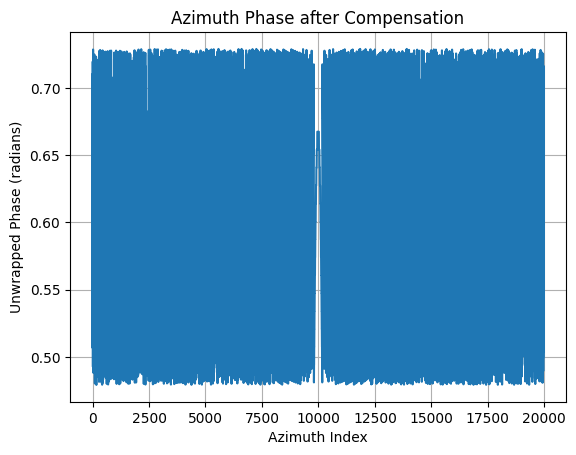

In [ ]:
import matplotlib.pyplot as plt

fast_time_idx = 10358
phase_profile = np.unwrap(np.angle(phase_correction[:, fast_time_idx]))

plt.plot(phase_profile)
plt.title("Azimuth Phase after Compensation")
plt.xlabel("Azimuth Index")
plt.ylabel("Unwrapped Phase (radians)")
plt.grid(True)
plt.show()


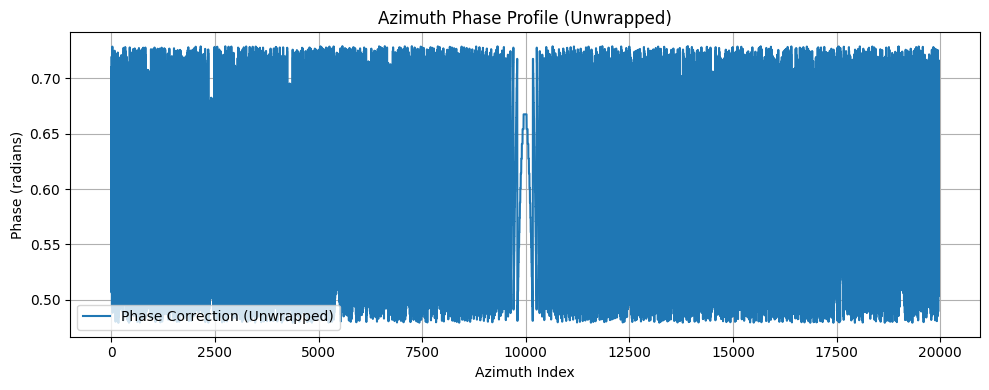

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Choose fast-time index where your peak lies
fast_time_idx = 10358  # Or replace with the actual index of interest

# Raw phases before and after correction
phase_before = np.angle(aligned_data[:, fast_time_idx])
phase_correction = np.angle(azimuth_phase_corrected[:, fast_time_idx])
phase_after = np.angle(azimuth_phase_corrected[:, fast_time_idx])

# Apply phase unwrapping across azimuth
phase_before_unwrapped = np.unwrap(phase_before)
phase_correction_unwrapped = np.unwrap(phase_correction)
phase_after_unwrapped = np.unwrap(phase_after)

# Plot the result
plt.figure(figsize=(10, 4))
# plt.plot(phase_before_unwrapped, label='Before Correction (Unwrapped)')
plt.plot(phase_correction_unwrapped, label='Phase Correction (Unwrapped)')
# plt.plot(phase_after_unwrapped, label='After Correction (Unwrapped)')
plt.xlabel('Azimuth Index')
plt.ylabel('Phase (radians)')
plt.title('Azimuth Phase Profile (Unwrapped)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


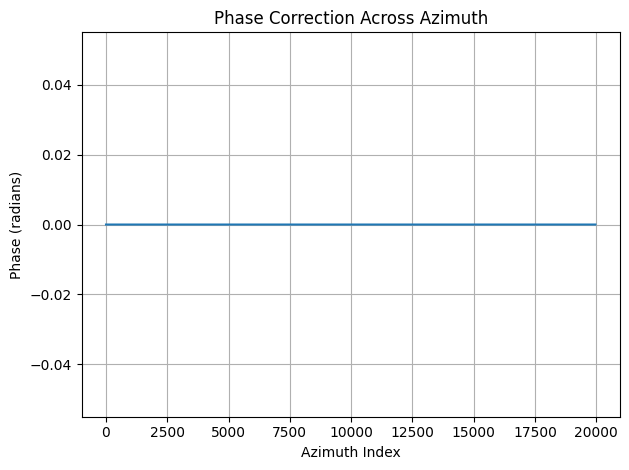

In [86]:
import matplotlib.pyplot as plt
plt.plot(np.unwrap(np.angle(phase_correction[:])))
plt.title("Phase Correction Across Azimuth")
plt.xlabel("Azimuth Index")
plt.ylabel("Phase (radians)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
# Check phase vs azimuth
print(phase_correction.shape)
plot_phase_vs_azimuth(phase_correction, sensor.sampling_frequency_hz, fast_time_us=0)

(19966,)


IndexError: tuple index out of range

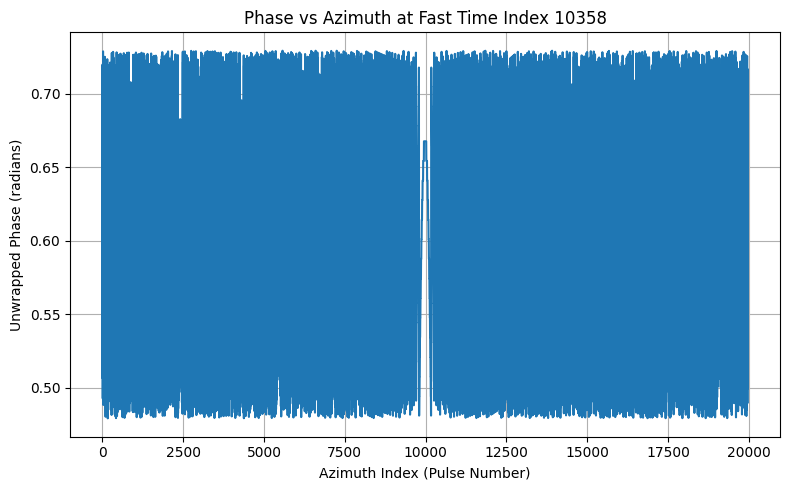

In [36]:
# Check phase vs azimut|h
plot_phase_vs_azimuth(azimuth_phase_corrected, sensor.sampling_frequency_hz, fast_time_us=10.76156)

In [13]:
import numpy as np

def simulate_azimuth_compression(aligned_data: np.ndarray, reference_azimuth: np.ndarray) -> np.ndarray:
    """
    Performs azimuth compression on aligned SAR data using a reference azimuth signal (matched filter).
    
    Parameters:
    - aligned_data: 2D complex ndarray [pulses x fast-time] (after range alignment)
    - reference_azimuth: 1D complex ndarray (the azimuth profile at a range bin, to use as matched filter)
    
    Returns:
    - final_image: 2D complex ndarray after azimuth compression [pulses x fast-time]
    """
    num_pulses, num_fast_time = aligned_data.shape

    # Prepare reference signal (complex conjugate for matched filtering)
    ref_conj = np.conj(reference_azimuth)
    ref_fft = np.fft.fft(ref_conj, n=num_pulses)

    # Allocate output
    final_image = np.zeros_like(aligned_data, dtype=np.complex64)

    # FFT-based convolution (azimuth compression for each fast-time bin)
    for rng_bin in range(num_fast_time):
        # Get azimuth signal at this range bin (i.e. slow time profile for this column)
        azimuth_profile = aligned_data[:, rng_bin]

        # FFT of azimuth signal
        az_fft = np.fft.fft(azimuth_profile)

        # Multiply with conjugate of reference FFT
        compressed_fft = az_fft * ref_fft

        # IFFT to get focused azimuth response
        final_image[:, rng_bin] = np.fft.ifft(compressed_fft)

    return final_image


In [14]:
# Perform azimuth compression
reference_azimuth = aligned_data[:, aligned_data.shape[1] // 2]  # Get one column as reference
# final_image = simulate_azimuth_compression(aligned_data, reference_azimuth)
# final_image = simulate_azimuth_compression(azimuth_phase_corrected, reference_azimuth)
# Cast to complex64 to save memory, and compute IFFT along azimuth (axis=0)
final_image = np.fft.ifft(azimuth_phase_corrected.astype(np.complex64), axis=0).astype(np.complex64)


In [15]:
ifft_shifted_image = np.fft.ifftshift(final_image)

In [16]:
print(np.max(ifft_shifted_image))

(2364.8835+1633.2467j)


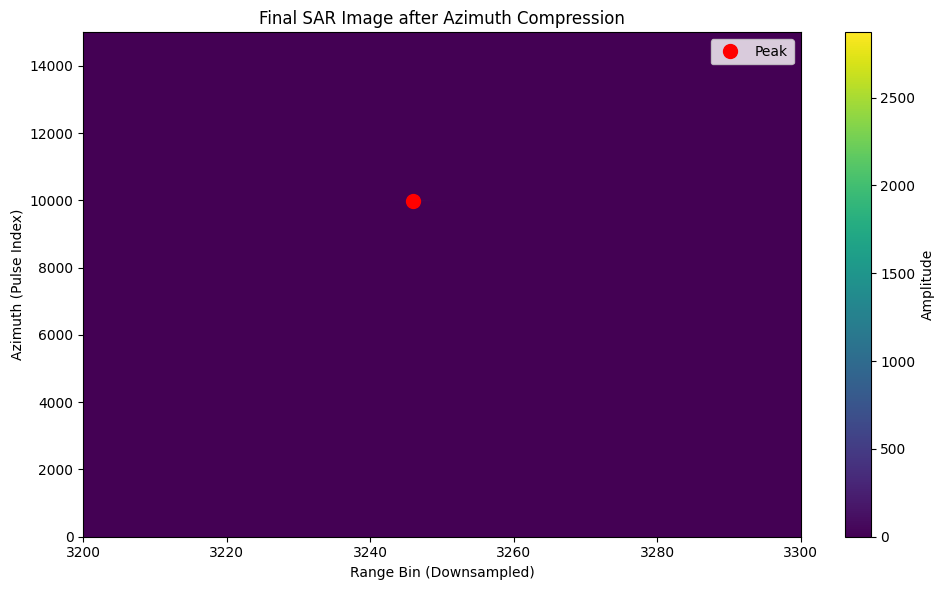

Peak at Azimuth Index = 9983, Range Bin = 32469 (Downsampled index = 3246)


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Find the peak (maximum amplitude in the image)
peak_idx = np.unravel_index(np.argmax(np.abs(ifft_shifted_image)), ifft_shifted_image.shape)
az_idx, rng_idx = peak_idx  # Row = azimuth index, Col = range index

# Downsample the range index for display
downsample_fast = 10
rng_idx_ds = rng_idx // downsample_fast

# Plot SAR image
plt.figure(figsize=(10, 6))
plt.imshow(
    np.abs(ifft_shifted_image)[:, ::downsample_fast],
    aspect='auto', cmap='viridis'
)
plt.colorbar(label='Amplitude')
plt.xlabel("Range Bin (Downsampled)")
plt.ylabel("Azimuth (Pulse Index)")
plt.title("Final SAR Image after Azimuth Compression")
plt.xlim(3200, 3300)
plt.ylim(0,15000)

# Mark the peak with a large red dot
plt.plot(rng_idx_ds, az_idx, 'ro', markersize=10, label='Peak')  # Increase size here
plt.legend()

plt.tight_layout()
plt.show()

# Print peak location
print(f"Peak at Azimuth Index = {az_idx}, Range Bin = {rng_idx} (Downsampled index = {rng_idx_ds})")


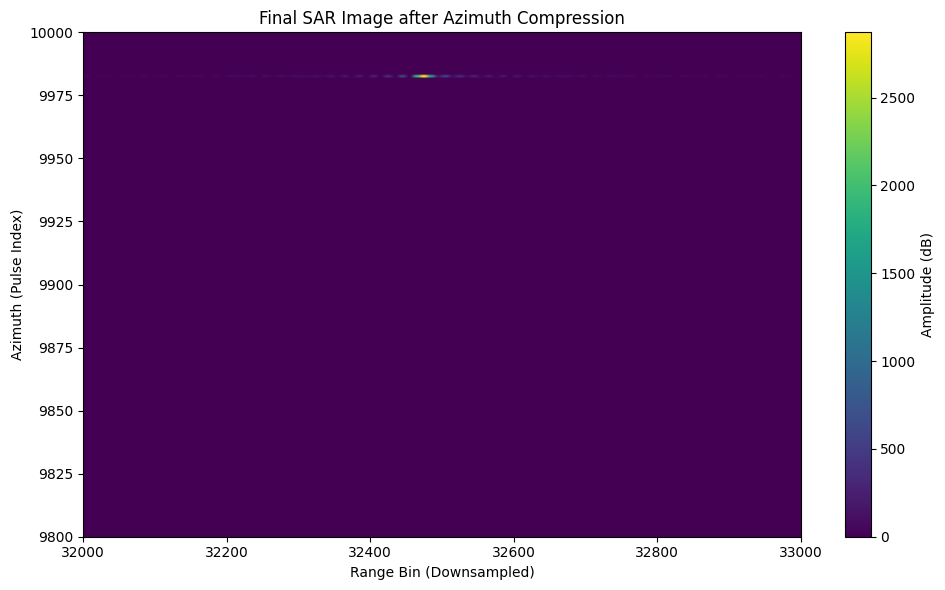

Peak at Azimuth Index = 9983, Range Bin = 32469 (Downsampled index = 3246)


In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Find the peak (maximum amplitude in the image)
peak_idx = np.unravel_index(np.argmax(np.abs(ifft_shifted_image)), ifft_shifted_image.shape)
az_idx, rng_idx = peak_idx

# Downsample for display
downsample_fast = 10
amplitude = np.abs(ifft_shifted_image)[:, ::downsample_fast]

# Plot using imshow
plt.figure(figsize=(10, 6))
plt.imshow(
    np.abs(amplitude),  # dB scale for clarity
    aspect='auto',
    cmap='viridis',
    extent=[
        0, amplitude.shape[1] * downsample_fast,  # X: range bins
        0, amplitude.shape[0]                   # Y: azimuth index
    ],
    origin='upper'
)

plt.colorbar(label='Amplitude (dB)')
plt.xlabel("Range Bin (Downsampled)")
plt.ylabel("Azimuth (Pulse Index)")
plt.title("Final SAR Image after Azimuth Compression")

# Apply zoom limits (matching your Plotly layout)
plt.xlim(32000, 33000)
plt.ylim(9800, 10000)  # flip Y axis like Plotly

plt.tight_layout()
plt.show()

# Print peak location
print(f"Peak at Azimuth Index = {az_idx}, Range Bin = {rng_idx} (Downsampled index = {rng_idx // downsample_fast})")


